In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
import torchvision
from PIL import Image
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets

np.random.seed(42)
%matplotlib inline
sns.set_style('darkgrid')


Bad key "text.kerning_factor" on line 4 in
C:\Users\higor\anaconda3\envs\pytorch-covid\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.003
TRAIN_DATA_PATH = "dataset_divided/train"
TEST_DATA_PATH = "dataset_divided/test"

loader = lambda x: Image.open(x)

class ToNorm(object):
    def __call__(self,img):
        mean = torch.mean(img)
        std  = torch.std(img)
        return (img - mean)/std
    

class ToRGB(object):
    def __call__(self,img):
        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            return Image.merge('RGB', (r, g, b))
        if img.mode == 'L':
            rgb = img.convert('RGB')
            return rgb
        return img


TRANSFORM_IMG = transforms.Compose([
    ToRGB(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ToNorm()
    ])

# Carregar imagens
train_data  = datasets.ImageFolder(TRAIN_DATA_PATH, loader=loader, transform=TRANSFORM_IMG)
print(train_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=999, shuffle=False)

data, class_att = next(iter(train_loader))

# Separar as folds com balanceamento das amostras

n_folds = 5

samples_per_label = [[] for i in range(len(train_data.classes))]

for i in range(len(train_data.samples)):
    samples_per_label[class_att[i]].append(data[i].view(3, 256, 256).numpy())

for i in range(len(samples_per_label)):
    samples_per_label[i] = np.random.permutation(samples_per_label[i])
    samples_per_label[i] = np.array_split(samples_per_label[i], n_folds)

folds = [[] for i in range(n_folds)]
folds_labels = [[] for i in range(n_folds)]

for i in range(n_folds):
    for j in range(len(samples_per_label)):
        folds[i].append(samples_per_label[j][i])
        labels = np.empty(len(samples_per_label[j][i]), dtype=int)
        labels.fill(j)
        folds_labels[i].append(labels)
    folds_labels[i] = np.concatenate(folds_labels[i][:])
    folds[i] = np.concatenate(folds[i][:])

Dataset ImageFolder
    Number of datapoints: 900
    Root location: dataset_divided/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [3]:
idx2class = {v: k for k, v in train_data.class_to_idx.items()}
print(idx2class)

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train_data), plot_title="Entire Dataset (before train/val/test split)")

{0: 'Covid-19', 1: 'No_findings', 2: 'Pneumonia'}


Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

Text(0.5, 1.0, 'Val Set')

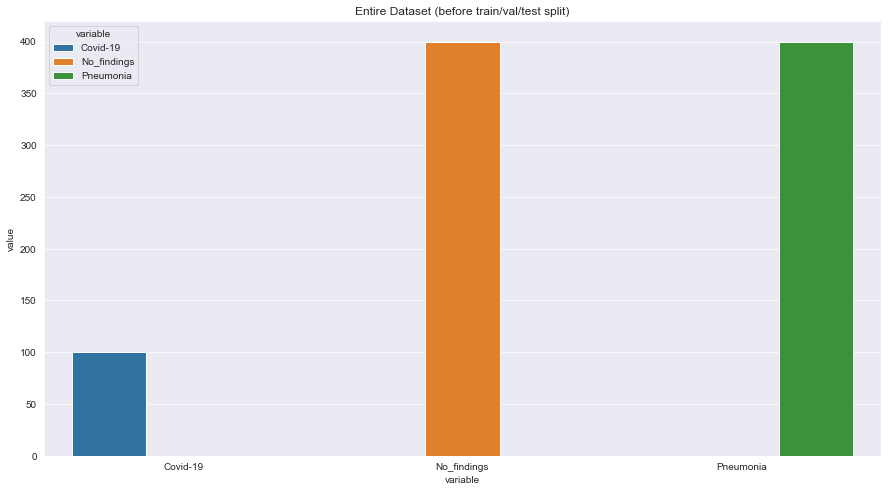

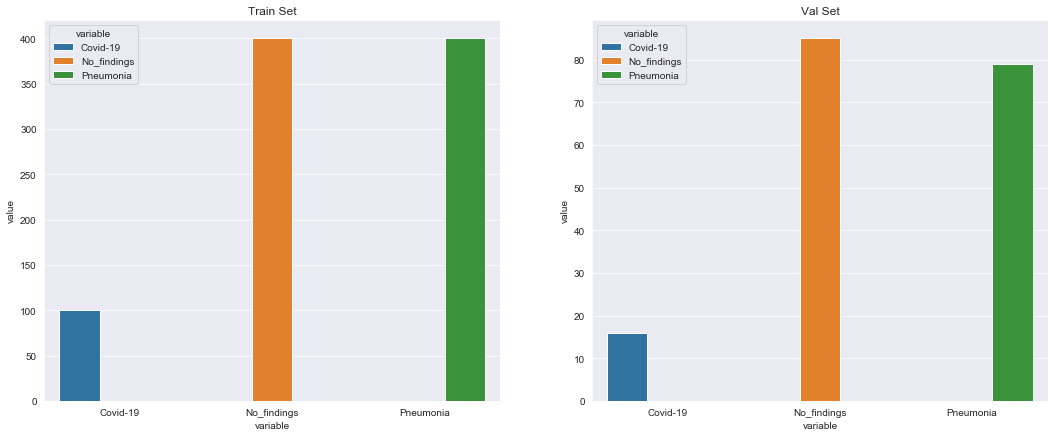

In [4]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    idx2class2 = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class2[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class2[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, train_data), plot_title="Train Set", ax=axes[0])
rps_dataset_size = len(train_data)
rps_dataset_indices = list(range(rps_dataset_size))
np.random.shuffle(rps_dataset_indices)
val_split_index = int(np.floor(0.2 * rps_dataset_size))
train_idx, val_idx = rps_dataset_indices[val_split_index:], rps_dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
val_loader = DataLoader(dataset=train_data, shuffle=False, batch_size=1, sampler=val_sampler)
plot_from_dict(get_class_distribution_loaders(val_loader, train_data), plot_title="Val Set", ax=axes[1])

In [5]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([900, 3, 256, 256])

In [6]:
print("Output label tensors: ", single_batch[1])
print("Output label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 

In [7]:
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


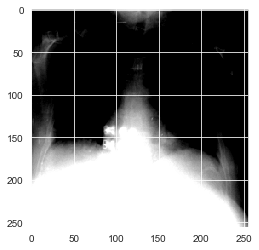

In [8]:
plt.imshow(single_image.permute(1, 2, 0))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )


def conv_layer(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(nf)  
    )
    

def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )


def maxpooling():
    return nn.MaxPool2d(2, stride=2)


class CovidCNN(nn.Module):
    def __init__(self):
        super(CovidCNN,self).__init__()
        self.covid = nn.Sequential(
            conv_block(3, 8),
            maxpooling(),
            conv_block(8, 16),
            maxpooling(),
            triple_conv(16, 32),
            maxpooling(),
            triple_conv(32, 64),
            maxpooling(),
            triple_conv(64, 128),
            maxpooling(),
            triple_conv(128, 256),
            conv_block(256, 128, size=1),
            conv_block(128, 256),
            conv_layer(256,3),
            nn.Flatten(),
            nn.Linear(507, 3)
        )
    def forward(self,x):
        x = self.covid(x)
        return x


model = CovidCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

We're using => cuda
CovidCNN(
  (covid): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative

In [10]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100
    return acc


accuracy_stats = {
    'train': [],
    'val': []
}
loss_stats = {
    'train': [],
    'val': []
}


In [11]:
folds_acc = [0.0 for i in range(n_folds)]

for i_fold in range(n_folds):
    train_dataset = np.concatenate([folds[i] for i in range(n_folds) if i != i_fold])
    val_dataset = folds[i_fold]
    train_labels = np.concatenate([folds_labels[i] for i in range(n_folds) if i != i_fold])
    val_labels = folds_labels[i_fold]

    train_dataset_tensor = torch.Tensor(train_dataset)
    train_labels_tensor = torch.Tensor(train_labels).long()

    test_dataset_tensor = torch.Tensor(val_dataset)
    val_labels_tensor = torch.Tensor(val_labels).long()

    train_dataset_torch = torch.utils.data.TensorDataset(train_dataset_tensor, train_labels_tensor)
    val_dataset_torch = torch.utils.data.TensorDataset(test_dataset_tensor, val_labels_tensor)

    train_data_loader = torch.utils.data.DataLoader(train_dataset_torch, batch_size=BATCH_SIZE, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_dataset_torch, batch_size=1, shuffle=False)

    print('Training fold ' + str(i_fold + 1) + '...')
    for epoch in range(EPOCHS):
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_data_loader:
            if torch.cuda.is_available():
                X_train_batch, y_train_batch = X_train_batch.cuda(), y_train_batch.cuda()
            optimizer.zero_grad()
            y_train_pred = model(X_train_batch).squeeze()
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)
            train_loss.backward()
            optimizer.step()
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
        # VALIDATION",
        with torch.no_grad():
            model.eval()
            val_epoch_loss = 0
            val_epoch_acc = 0
            for X_val_batch, y_val_batch in val_data_loader:
                if torch.cuda.is_available():
                    X_val_batch, y_val_batch = X_val_batch.cuda(), y_val_batch.cuda()
                y_val_pred = model(X_val_batch).squeeze()
                y_val_pred = torch.unsqueeze(y_val_pred, 0)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        loss_stats['train'].append(train_epoch_loss/len(train_data_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_data_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_data_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_data_loader))
        # TODO usar apenas os ultimos valores da validação cruzada ou fazer uma média por dobra
        if (epoch % 10 == 0) or (epoch == EPOCHS-1):
            print(f'Epoch {epoch+0:02}: | Train Loss: {train_epoch_loss/len(train_data_loader):.5f} | Val Loss: {val_epoch_loss/len(val_data_loader):.5f} | Train Acc: {train_epoch_acc/len(train_data_loader):.3f}| Val Acc: {val_epoch_acc/len(val_data_loader):.3f}')
    
    model = CovidCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    

Training fold 1...
Epoch 00: | Train Loss: 0.86600 | Val Loss: 1.10309 | Train Acc: 69.565| Val Acc: 37.778
Epoch 04: | Train Loss: 0.29606 | Val Loss: 0.89058 | Train Acc: 100.000| Val Acc: 66.667
Training fold 2...
Epoch 00: | Train Loss: 0.86962 | Val Loss: 1.02909 | Train Acc: 78.261| Val Acc: 44.444
Epoch 04: | Train Loss: 0.18887 | Val Loss: 0.49032 | Train Acc: 100.000| Val Acc: 81.111
Training fold 3...
Epoch 00: | Train Loss: 0.83950 | Val Loss: 1.20511 | Train Acc: 82.609| Val Acc: 11.111
Epoch 04: | Train Loss: 0.27284 | Val Loss: 0.65644 | Train Acc: 100.000| Val Acc: 70.556
Training fold 4...
Epoch 00: | Train Loss: 0.94786 | Val Loss: 1.10390 | Train Acc: 56.522| Val Acc: 42.778
Epoch 04: | Train Loss: 0.23836 | Val Loss: 0.52448 | Train Acc: 100.000| Val Acc: 78.333
Training fold 5...
Epoch 00: | Train Loss: 0.88665 | Val Loss: 1.02081 | Train Acc: 52.174| Val Acc: 44.444
Epoch 04: | Train Loss: 0.26196 | Val Loss: 0.63509 | Train Acc: 100.000| Val Acc: 75.000


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

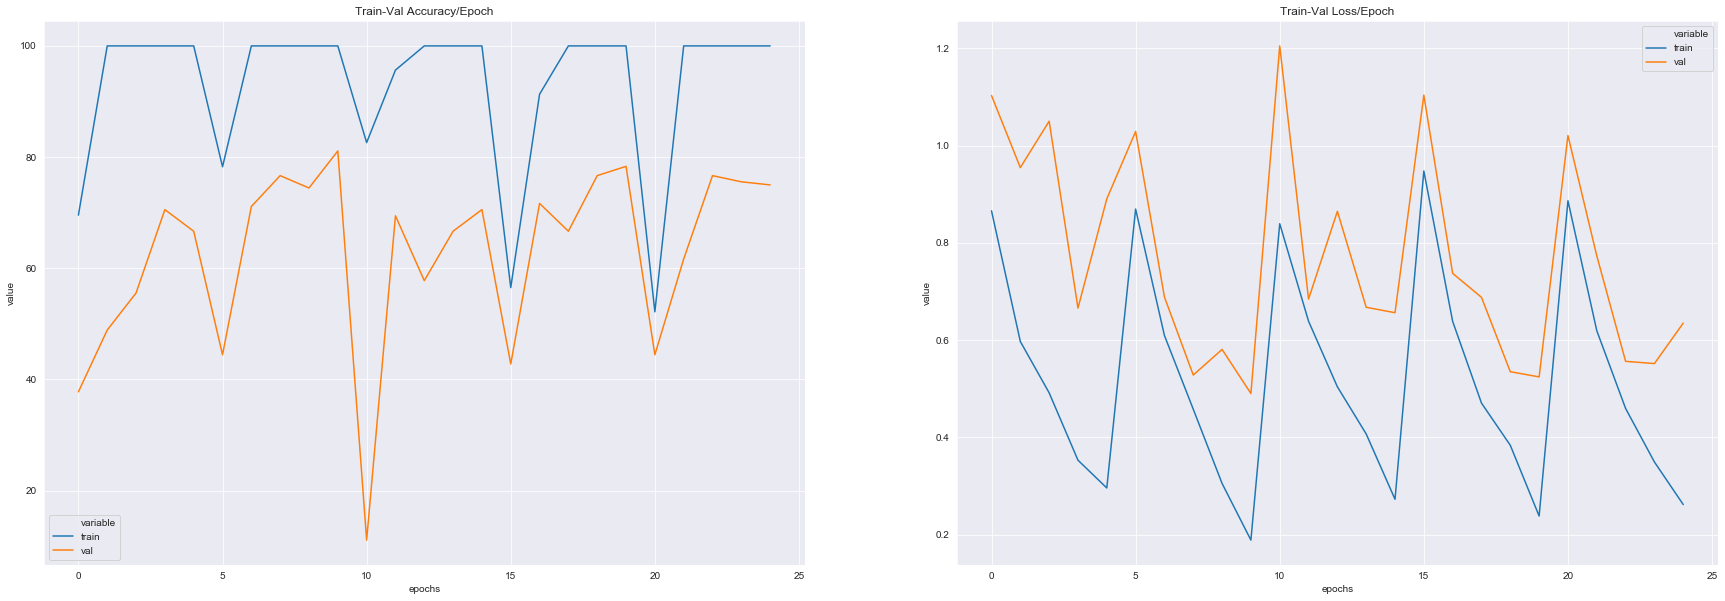

In [12]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [13]:
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
print(test_data)
test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=1)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: dataset_divided/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [14]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

print(classification_report(y_true_list, y_pred_list))


              precision    recall  f1-score   support

           0       0.14      0.44      0.21        25
           1       0.46      0.57      0.51       100
           2       0.27      0.06      0.10       100

    accuracy                           0.33       225
   macro avg       0.29      0.36      0.27       225
weighted avg       0.34      0.33      0.29       225



In [15]:
print(confusion_matrix(y_true_list, y_pred_list))

[[11 11  3]
 [30 57 13]
 [39 55  6]]


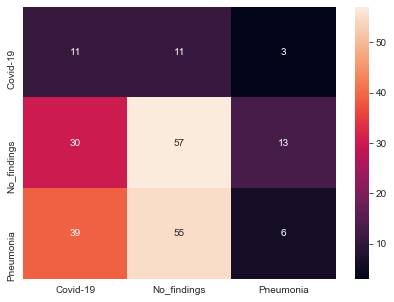

In [16]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
